In [3]:
import math
import pathlib
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
import seaborn as sns
import torch
import torch.nn as nn
import torchaudio
from math import ceil, pi
from scipy.io import loadmat

sns.set_style('white')
pd.options.display.max_columns = None
pd.options.display.width = 250

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

mat = loadmat("signal.mat")['x']
x = torch.from_numpy(mat).float().to('cuda')[:, 4_000:10_000]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def loss(x):
    # Create a small value to add to the logarithm to prevent numerical errors
    eps = torch.finfo(x.dtype).eps
    # Create a small value to clamp the logarithm to prevent numerical errors
    min = torch.finfo(x.dtype).min
    
    # Reshape x to have the shape (batch size, number of elements)
    x1 = torch.reshape(x, (x.shape[0], -1)) # B, N 
    # Normalize x1 so that the elements in each row sum to 1
    probs = torch.div(x1.T, x1.sum(dim=-1)).T # B, N
    
    # Calculate the entropy of the normalized elements
    entropy = -(probs * torch.clamp(torch.log(probs), min=min)).sum(dim=-1) # B
    # Return the mean entropy across the batch
    return entropy.mean()

In [5]:
class MySpec(nn.Module):
    def __init__(self, x,
                    win_length: float,   
                    N: int,                 
                    stride: int, 
                    params: str = 'p_tf', # p, p_t, p_f, p_tf
                    pow: float = 1.0,
                    requires_grad: bool = True,                 
                    tapering_function: str = 'hann',
                    sr : int = 16_000,
                    ):
        super(MySpec, self).__init__()        
        
        self.win_length = None        
        self.init_win_length = win_length
        self.requires_grad = requires_grad        
        self.stride = stride        
        self.kernel_size = N 
        self.register_buffer('epsilon', torch.tensor(torch.finfo(torch.float).eps))
        self.tapering_function = tapering_function
        self.sr = sr
        # Calculate the number of frames
        self.T = int(1 + torch.div(x.shape[-1] - (self.kernel_size - 1) - 1, self.stride, rounding_mode='floor'))         
        # Determine the shape of the window length parameters
        if params == 'p':
            win_length_size = (1)
        elif params == 'p_t':
            win_length_size = (1, self.T)
        elif params == 'p_f':
            win_length_size = (1, self.kernel_size)
        elif params == 'p_tf':
            win_length_size = (1, self.kernel_size, self.T)
        # Create the window length parameter and assign it the appropriate shape
        win_length = abs(self.init_win_length) * torch.ones(win_length_size, requires_grad=self.requires_grad, dtype=x.dtype, device=x.device)
        self.win_length = nn.Parameter(win_length, requires_grad=self.requires_grad)
        self.pow = nn.Parameter(torch.tensor([pow], device=x.device), requires_grad=False)
        
    def forward(self, x):
        # Perform the forward STFT and extract the magnitude, phase, real, and imaginary parts
        stft = self.stft(x, 'forward')
        real, imag, spec, phase = stft.real, stft.imag, stft.abs().pow(self.pow)[:, :int(self.kernel_size/2+1)], stft.angle()[:, :int(self.kernel_size/2+1)]
        eps = torch.finfo(x.dtype).eps
        return spec + eps, stft 
    
    def backward(self, x, dl_ds):
        # Compute the gradient of the loss w.r.t. window length parameter with the chain rule
        dstft_dp = self.stft(x, 'backward')
        dl_dp = (torch.conj(dl_ds) * dstft_dp).sum().real #dl_dp = (dl_ds.real * dstft_dp.real + dl_ds.imag * dstft_dp.imag).sum()        
        return dl_dp.unsqueeze(0)
    
    def stft(self, x: torch.tensor, direction: str):
        batch_size, length, device, dtype = x.shape[0], x.shape[-1], x.device, x.dtype        
        # Generate the tapering window function for the STFT
        tap_win = self.window_function(direction=direction, dtype=dtype, device=device).permute(2, 1, 0)    
        #Generate Fourier coefficients    
        coeff = torch.arange(end=self.kernel_size, device=device, dtype=dtype, requires_grad=False)
        coeff = coeff[:, None] @ coeff[None, :]
        coeff = torch.exp(- 2j * pi * coeff / self.kernel_size)     
        # Calculate the number of frames
        self.T = int(1 + torch.div(length - (self.kernel_size - 1) - 1, self.stride, rounding_mode='floor'))
        strided_x = x.as_strided((batch_size, self.T, self.kernel_size), (batch_size, self.stride, 1))           
        strided_x = strided_x[:, :, None, :]
        tap_win = tap_win[None, :, :, :]
        coeff = coeff[None, None, :, :]                
        tapered_x = (strided_x * tap_win)[:, :, :, :, None]
        tapered_x = torch.view_as_complex(torch.cat((tapered_x, torch.zeros_like(tapered_x)), -1))        
        # Perform the STFT
        stft = (tapered_x * coeff).sum(dim=-1)
        stft = stft.permute(0, 2, 1)        
        return stft
        
    def window_function(self, direction: str, dtype, device) -> torch.tensor:
        if self.tapering_function not in {'hann', 'hanning',}:
            raise ValueError(f"tapering_function must be one of '{'hann', 'hanning',}', but got padding_mode='{self.tapering_function}'")
        else:
            # Create an array of indices to use as the base for the window function
            base = torch.arange(0, self.kernel_size, 1, dtype=dtype, device=device)[:, None, None].expand([-1, self.kernel_size, self.T])   
            # Expand the win_length parameter to match the shape of the base array         
            if self.win_length.dim() == 3:
                self.expanded_win_length = self.win_length.expand([self.kernel_size, self.kernel_size, self.T])
            elif self.win_length.dim() == 1:
                self.expanded_win_length = self.win_length[:, None, None].expand([self.kernel_size, self.kernel_size, self.T])
            elif self.win_length.dim() == 2 and self.win_length.shape[-1] == self.T:
                self.expanded_win_length = self.win_length[:, None, :].expand([self.kernel_size, self.kernel_size, self.T])
            elif self.win_length.dim() == 2 and self.win_length.shape[-1] == self.kernel_size: 
                self.expanded_win_length = self.win_length[:, :, None].expand([self.kernel_size, self.kernel_size, self.T])          
        
        # calculate the tapering function and its derivate w.r.t. window length
        if self.tapering_function == 'hann' or self.tapering_function == 'hanning':
            tap_win = 0.5 - 0.5 * torch.cos(2 * pi * (base + (self.expanded_win_length-self.kernel_size+1)/2) / self.expanded_win_length )              
            if (base.shape[-1] == self.win_length.shape[-1]) or self.win_length.shape[-1] == 1:
                mask1 = base.ge(torch.ceil( (self.kernel_size-1+self.win_length)/2))
                mask2 = base.le(torch.floor((self.kernel_size-1-self.win_length)/2))            
            else:
                mask1 = base.ge(torch.ceil( (self.kernel_size-1+self.win_length.permute(-1, -2))/2))
                mask2 = base.le(torch.floor((self.kernel_size-1-self.win_length.permute(-1, -2))/2))
            tap_win[mask1] = 0
            tap_win[mask2] = 0
            f = torch.sin(2 * pi * (base - (self.kernel_size-1)/2) / self.expanded_win_length)            
            d_tap_win = - pi / self.expanded_win_length * ((self.kernel_size-1)/2 - base) * f
            d_tap_win[mask1] = 0
            d_tap_win[mask2] = 0
            
            
        tap_win = tap_win / tap_win.sum(dim=0, keepdim=True)        
        if direction == 'forward':
            return tap_win
        elif direction == 'backward':
            return d_tap_win

Text(0.5, 0, 'frames')

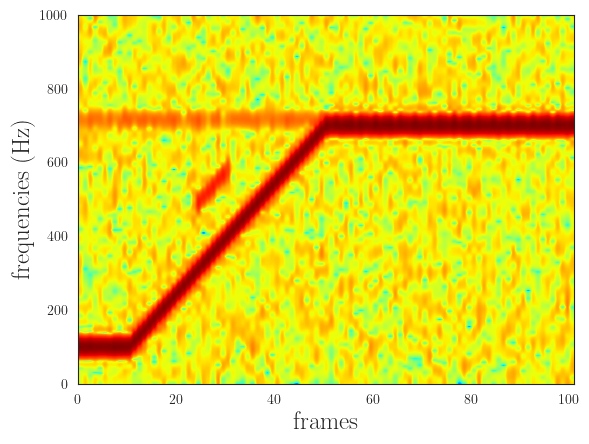

In [6]:
spec, _ = MySpec(x, win_length=100, N=1_000, stride=50, requires_grad=False, params='p')(x)
plt.imshow(spec[0].log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1000])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

Text(0.5, 0, 'frames')

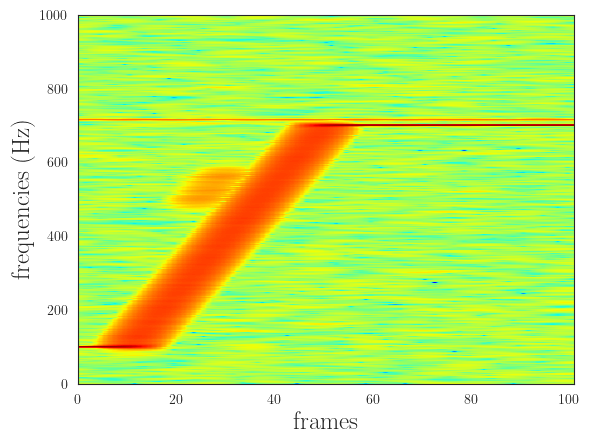

In [7]:
spec, _ = MySpec(x, win_length=1000, N=1_000, stride=50, requires_grad=False, params='p')(x)
plt.imshow(spec[0].log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1000])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

## p

Epoch 00060: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00111: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00162: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00213: reducing learning rate of group 0 to 1.0000e-02.


Text(0.5, 0, 'frames')

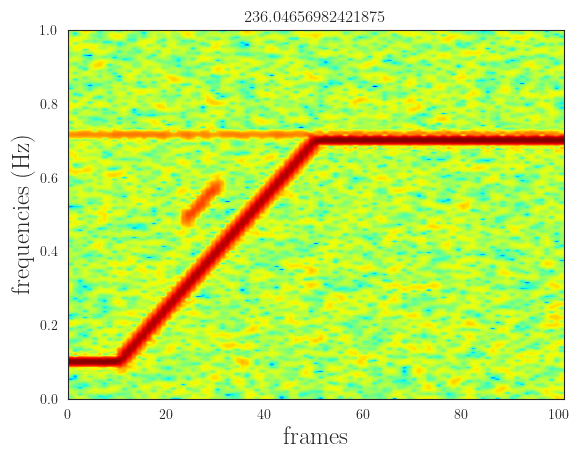

In [8]:
mystft = MySpec(x, win_length=577, N=1_000, stride=50, requires_grad=True, params='p')
opt = torch.optim.Adam(mystft.parameters(), lr=100)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=50, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, _ = mystft(x)
    err = loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    with torch.no_grad():
        mystft.win_length.clamp_(mystft.kernel_size/10, mystft.kernel_size)

    if opt.param_groups[0]['lr'] < .1:
        break
    
plt.title(mystft.win_length.data.item())
plt.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)
#plt.figure()
#ax = plt.subplot()
#im = ax.imshow(mystft.expanded_win_length[0, :mystft.kernel_size//2+1].detach().cpu(), aspect='auto', origin='lower', cmap='jet')
#plt.colorbar(im, ax=ax)
#im.set_clim(mystft.kernel_size/10, mystft.kernel_size) 
#ax.set_ylabel('frequencies (Hz)', fontsize=18)
#ax.set_xlabel('frames', fontsize=18)

## p_t

Epoch 00084: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00135: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00186: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00237: reducing learning rate of group 0 to 1.0000e-02.


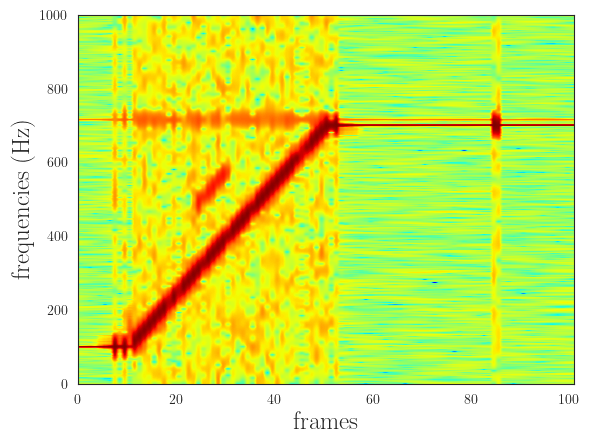

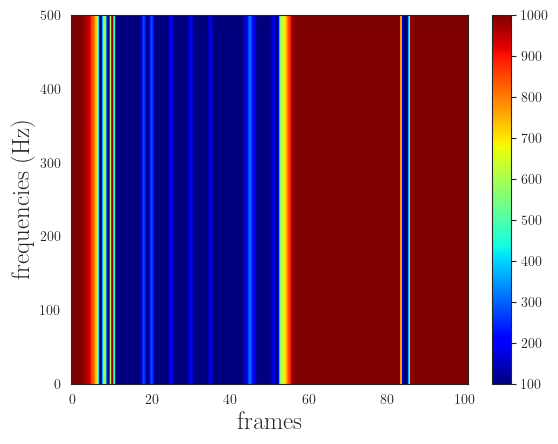

In [9]:
mystft = MySpec(x, win_length=577, N=1_000, stride=50, requires_grad=True, params='p_t')
opt = torch.optim.Adam(mystft.parameters(), lr=100)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=50, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, _ = mystft(x)
    err = loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    with torch.no_grad():
        mystft.win_length.clamp_(mystft.kernel_size/10, mystft.kernel_size)  

    if opt.param_groups[0]['lr'] < .1:
        break
plt.figure()
plt.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1000])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

plt.figure()
ax = plt.subplot()
im = ax.imshow(mystft.expanded_win_length[0, :mystft.kernel_size//2+1].detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies (Hz)', fontsize=18)
ax.set_xlabel('frames', fontsize=18)
plt.colorbar(im, ax=ax)
im.set_clim(mystft.kernel_size/10, mystft.kernel_size)      

Epoch 00085: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00159: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00210: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00261: reducing learning rate of group 0 to 1.0000e-02.


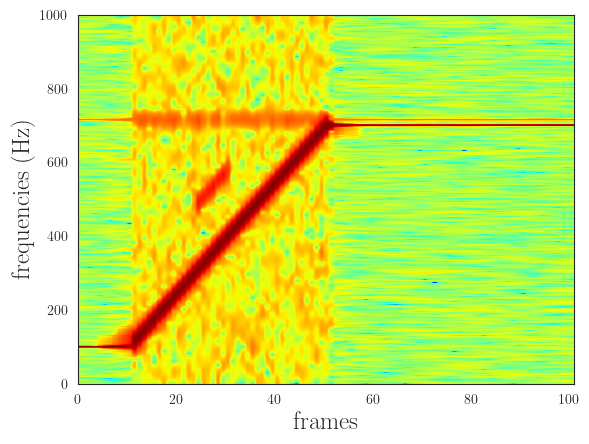

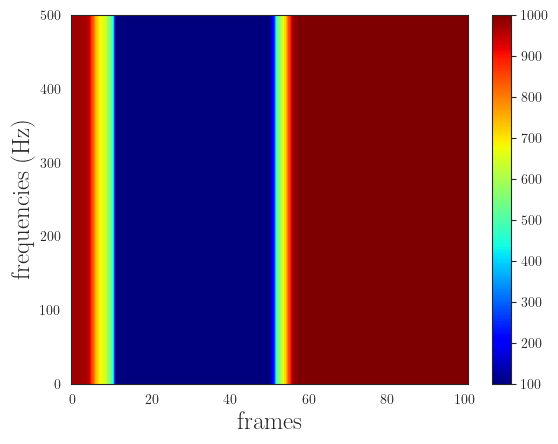

In [10]:
mystft = MySpec(x, win_length=577, N=1_000, stride=50, requires_grad=True, params='p_t')
opt = torch.optim.Adam(mystft.parameters(), lr=100)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=50, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, _ = mystft(x)
    err = loss(spec) + 0.001 * (mystft.expanded_win_length.diff(dim=1)[..., :-1].pow(2) + mystft.expanded_win_length.diff(dim=2)[:, :-1, :].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    with torch.no_grad():
        mystft.win_length.clamp_(mystft.kernel_size/10, mystft.kernel_size)

    if opt.param_groups[0]['lr'] < .1:
        break
    
plt.figure()
plt.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1000])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

plt.figure()
ax = plt.subplot()
im = ax.imshow(mystft.expanded_win_length[0, :mystft.kernel_size//2+1].detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies (Hz)', fontsize=18)
ax.set_xlabel('frames', fontsize=18)
plt.colorbar(im, ax=ax)
im.set_clim(mystft.kernel_size/10, mystft.kernel_size) 

## p_f

Epoch 00096: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00147: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00198: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00249: reducing learning rate of group 0 to 1.0000e-02.


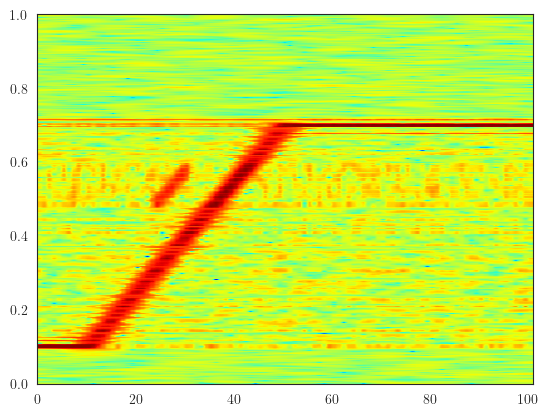

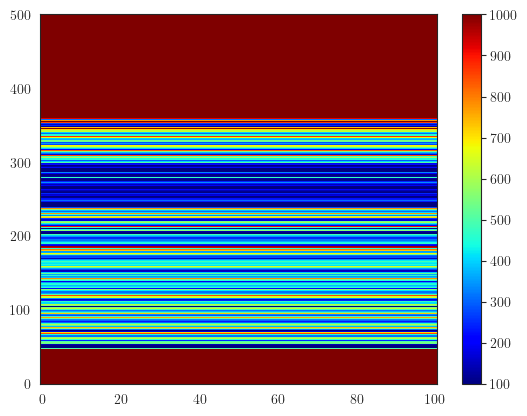

In [11]:
mystft = MySpec(x, win_length=577, N=1_000, stride=50, requires_grad=True, params='p_f')
opt = torch.optim.Adam(mystft.parameters(), lr=100)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=50, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, _ = mystft(x)
    err = loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    with torch.no_grad():
        mystft.win_length.clamp_(mystft.kernel_size/10, mystft.kernel_size)

    if opt.param_groups[0]['lr'] < .1:
        break
    
plt.figure()
plt.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1])

plt.figure()
ax = plt.subplot()
im = ax.imshow(mystft.expanded_win_length[0, :mystft.kernel_size//2+1].detach().cpu(), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(im, ax=ax)
im.set_clim(mystft.kernel_size/10, mystft.kernel_size) 

Epoch 00083: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00155: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00233: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00284: reducing learning rate of group 0 to 1.0000e-02.


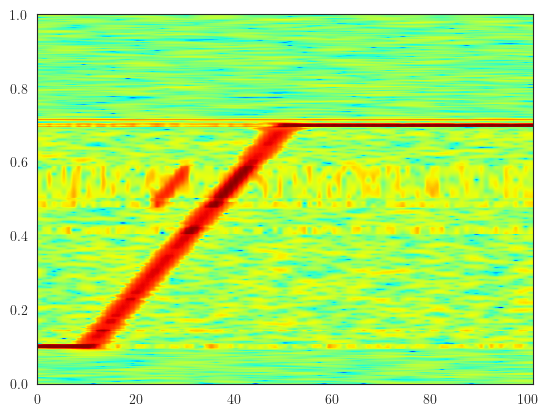

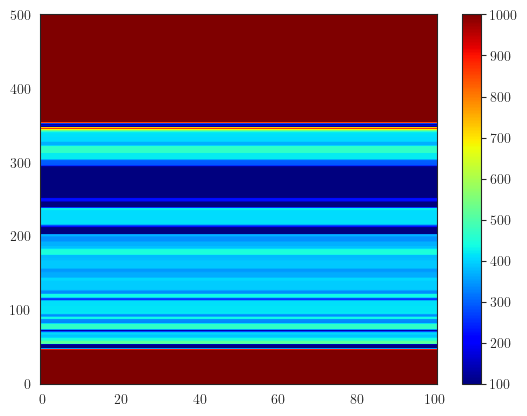

In [12]:
mystft = MySpec(x, win_length=577, N=1_000, stride=50, requires_grad=True, params='p_f')
opt = torch.optim.Adam(mystft.parameters(), lr=100)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=50, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, _ = mystft(x)
    err = loss(spec) + 0.001 * (mystft.expanded_win_length.diff(dim=1)[..., :-1].pow(2) + mystft.expanded_win_length.diff(dim=2)[:, :-1, :].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    with torch.no_grad():
        mystft.win_length.clamp_(mystft.kernel_size/10, mystft.kernel_size)

    if opt.param_groups[0]['lr'] < .1:
        break
    
plt.figure()
plt.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1])

plt.figure()
ax = plt.subplot()
im = ax.imshow(mystft.expanded_win_length[0, :mystft.kernel_size//2+1].detach().cpu(), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(im, ax=ax)
im.set_clim(mystft.kernel_size/10, mystft.kernel_size) 

## p_tf

Epoch 00166: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00257: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00308: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00359: reducing learning rate of group 0 to 1.0000e-02.


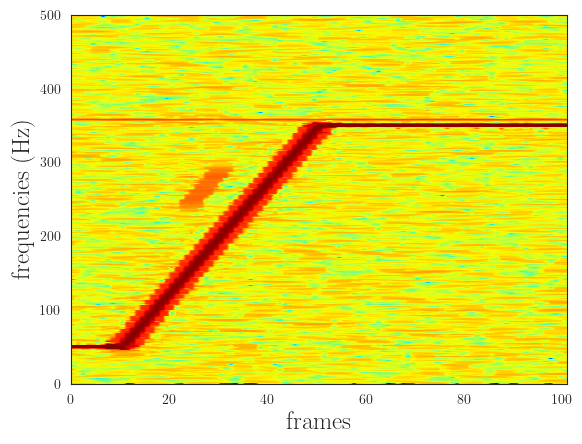

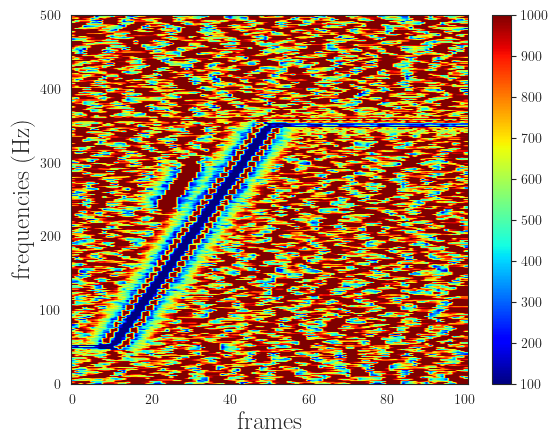

In [13]:
mystft = MySpec(x, win_length=577, N=1_000, stride=50, requires_grad=True, params='p_tf')
opt = torch.optim.Adam(mystft.parameters(), lr=100)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=50, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, _ = mystft(x)
    err = loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    with torch.no_grad():
        mystft.win_length.clamp_(mystft.kernel_size/10, mystft.kernel_size)

    if opt.param_groups[0]['lr'] < .1:
        break
    
plt.figure()
plt.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 500])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

plt.figure()
ax = plt.subplot()
im = ax.imshow(mystft.expanded_win_length[0, :mystft.kernel_size//2+1].detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies (Hz)', fontsize=18)
ax.set_xlabel('frames', fontsize=18)
plt.colorbar(im, ax=ax)
im.set_clim(mystft.kernel_size/10, mystft.kernel_size)     

Epoch 00147: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00242: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00315: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00371: reducing learning rate of group 0 to 1.0000e-02.


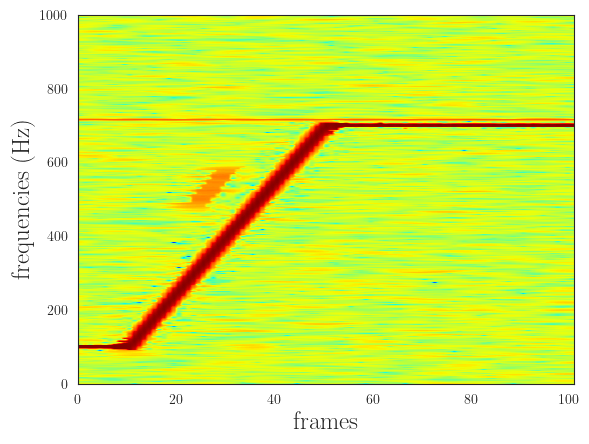

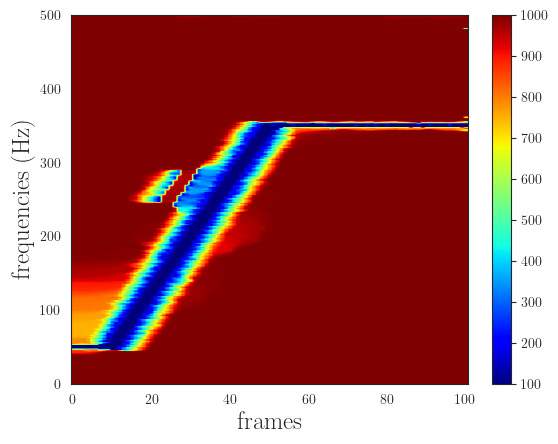

In [14]:
mystft = MySpec(x, win_length=577, N=1_000, stride=50, requires_grad=True, params='p_tf')
opt = torch.optim.Adam(mystft.parameters(), lr=100)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=50, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, _ = mystft(x)
    err = loss(spec) + 0.01 * (mystft.expanded_win_length.diff(dim=1)[..., :-1].pow(2) + mystft.expanded_win_length.diff(dim=2)[:, :-1, :].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    with torch.no_grad():
        mystft.win_length.clamp_(mystft.kernel_size/10, mystft.kernel_size)

    if opt.param_groups[0]['lr'] < .1:
        break
plt.figure()
plt.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, 1000])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

plt.figure()
ax = plt.subplot()
im = ax.imshow(mystft.expanded_win_length[0, :mystft.kernel_size//2+1].detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies (Hz)', fontsize=18)
ax.set_xlabel('frames', fontsize=18)
plt.colorbar(im, ax=ax)
im.set_clim(mystft.kernel_size/10, mystft.kernel_size) 